## Imports

In [1]:
import sys
sys.path.append("/N/u/jmelms/BigRed200/FCN_Otis/data_analysis") # I know this a terrible kludgey fix, but I don't have a better one right now
from processing_utils import process_fcn_output

import xarray as xr
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize

import pathlib
from pathlib import Path
from time import perf_counter_ns

## Load and Process Data

All of the actual work is handled in the "processing utils" function called below - see `/N/u/jmelms/BigRed200/FCN_Otis/data_analysis/processing_utils.py` to modify the config for loading data, or the obsolete notebook somewhere around here that details it further. If you modify the util function and want to see the notebook update, you'll have to restart the kernel to reload modules (they all get cached by default), or you can add the "autoreload" extension.

In [2]:
start = perf_counter_ns()
pred, time = process_fcn_output()
stop = perf_counter_ns()
diff = stop - start
time_fmt = "%Hz-%b%d"
lat = np.load("/N/u/jmelms/BigRed200/FCN_Otis/latitude.npy")
lon = np.load("/N/u/jmelms/BigRed200/FCN_Otis/longitude.npy")
get_idx = lambda val, arr: np.argmin(np.abs(arr - val))
land_mask_path = "/N/u/jmelms/BigRed200/FCN_Otis/land_sea_edges_mask.npy"
land_mask = np.load(land_mask_path)
str_t = lambda ic, t: time[ic, t].strftime(time_fmt)
print(f"Loading and processing data took {diff/1_000_000_000:.3f} seconds\n\n")
print(f"Example: IC #18 times \n{time[18]}\n\n")
print("Data: ")
pred

Loading and processing data took 23.915 seconds


Example: IC #18 times 
[cftime.DatetimeProlepticGregorian(2023, 10, 22, 12, 0, 0, 2, has_year_zero=True)
 cftime.DatetimeProlepticGregorian(2023, 10, 22, 18, 0, 0, 2, has_year_zero=True)
 cftime.DatetimeProlepticGregorian(2023, 10, 23, 0, 0, 0, 2, has_year_zero=True)
 cftime.DatetimeProlepticGregorian(2023, 10, 23, 6, 0, 0, 2, has_year_zero=True)
 cftime.DatetimeProlepticGregorian(2023, 10, 23, 12, 0, 0, 2, has_year_zero=True)
 cftime.DatetimeProlepticGregorian(2023, 10, 23, 18, 0, 0, 2, has_year_zero=True)
 cftime.DatetimeProlepticGregorian(2023, 10, 24, 0, 0, 0, 2, has_year_zero=True)
 cftime.DatetimeProlepticGregorian(2023, 10, 24, 6, 0, 0, 2, has_year_zero=True)
 cftime.DatetimeProlepticGregorian(2023, 10, 24, 12, 0, 0, 2, has_year_zero=True)
 cftime.DatetimeProlepticGregorian(2023, 10, 24, 18, 0, 0, 2, has_year_zero=True)
 cftime.DatetimeProlepticGregorian(2023, 10, 25, 0, 0, 0, 2, has_year_zero=True)
 cftime.DatetimeProlepticGrego

<xarray.DataArray 'predicted' (ic: 35, t: 21, channel: 4, lat: 720, lon: 1440)>
array([[[[[ 1.61902734e+00,  1.61902734e+00,  1.61902734e+00, ...,
            1.61902734e+00,  1.61902734e+00,  1.61902734e+00],
          [-1.35639583e+00, -1.35551320e+00, -1.35463057e+00, ...,
           -1.36257447e+00, -1.36080905e+00, -1.35904388e+00],
          [-1.23194184e+00, -1.22752853e+00, -1.22576320e+00, ...,
           -1.24606421e+00, -1.24253354e+00, -1.23723769e+00],
          ...,
          [-4.55601256e+00, -4.53041611e+00, -4.50481900e+00, ...,
           -4.61956341e+00, -4.59838002e+00, -4.57719663e+00],
          [-4.26561984e+00, -4.24973204e+00, -4.22413526e+00, ...,
           -4.32387509e+00, -4.30004373e+00, -4.28062476e+00],
          [-3.52066083e+00, -3.50565591e+00, -3.48976811e+00, ...,
           -3.55861490e+00, -3.54625761e+00, -3.53390066e+00]],

         [[ 3.21277708e-01,  3.21277708e-01,  3.21277708e-01, ...,
            3.21277708e-01,  3.21277708e-01,  3.21277708e-01],
          [ 2.83604742e-01,  2.85242677e-01,  2.86061674e-01, ...,
            2.79509843e-01,  2.80328810e-01,  2.81966775e-01],
          [ 2.89026236e-02,  2.80836472e-02,  2.97216000e-02, ...,
            2.39887651e-02,  2.72646708e-02,  2.89026236e-02],
...
          [ 2.31259521e+02,  2.31284059e+02,  2.31256114e+02, ...,
            2.30515235e+02,  2.30445808e+02,  2.30476394e+02],
          [ 2.31270247e+02,  2.31218897e+02,  2.31097742e+02, ...,
            2.30288515e+02,  2.30089515e+02,  2.30136988e+02],
          [ 2.30820382e+02,  2.30987549e+02,  2.31040748e+02, ...,
            2.29955402e+02,  2.29856507e+02,  2.29681535e+02]],

         [[ 1.00091260e+05,  1.00104415e+05,  1.00115577e+05, ...,
            1.00189509e+05,  1.00197074e+05,  1.00187255e+05],
          [ 1.00119746e+05,  1.00140751e+05,  1.00139422e+05, ...,
            1.00205684e+05,  1.00198808e+05,  1.00195599e+05],
          [ 1.00137317e+05,  1.00169931e+05,  1.00173696e+05, ...,
            1.00231593e+05,  1.00231827e+05,  1.00201189e+05],
          ...,
          [ 9.91489879e+04,  9.91394980e+04,  9.91512787e+04, ...,
            9.92146430e+04,  9.91939799e+04,  9.91923144e+04],
          [ 9.91321033e+04,  9.91340557e+04,  9.91403775e+04, ...,
            9.92031776e+04,  9.92091017e+04,  9.92103403e+04],
          [ 9.91293492e+04,  9.91177434e+04,  9.91196483e+04, ...,
            9.92017136e+04,  9.92088047e+04,  9.92161272e+04]]]]])
Coordinates:
  * lat      (lat) float32 90.0 89.75 89.5 89.25 ... -89.0 -89.25 -89.5 -89.75
  * lon      (lon) float32 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
  * channel  (channel) <U5 'u10' 'v10' 't2m' 'mslp'
Dimensions without coordinates: ic, t

## Basic Heatmap

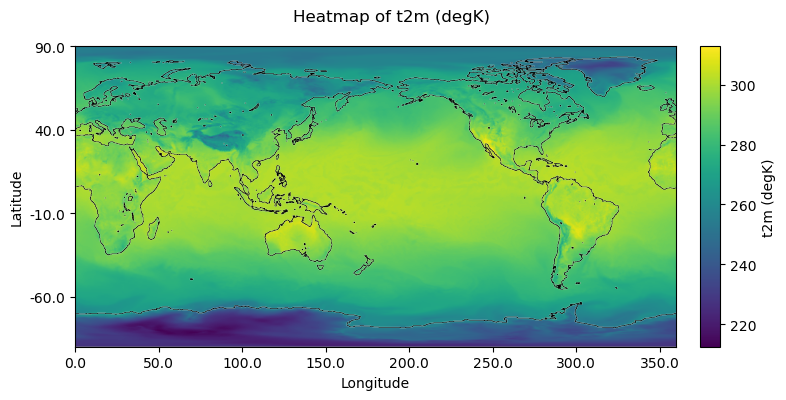

In [3]:
def context():
    ic = 0
    t = 0
    channel = "t2m"
    units = "degK"
    tstep = pred.sel(ic=ic, t=t, channel=channel)
    xticks = np.arange(0, tstep.lon.values.size, 200)
    yticks = np.arange(0, tstep.lat.values.size, 200)
    xticklabs = tstep.lon.values[xticks]
    yticklabs = tstep.lat.values[yticks]
    
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 3.9), gridspec_kw={'width_ratios': [30, 1]})
    ax1.imshow(tstep, cmap='viridis')
    norm = Normalize(vmin=tstep.min(), vmax=tstep.max())
    cmap = cm.viridis
    scalar_mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
    fig.colorbar(scalar_mappable, label=f"{channel} ({units})", cax=ax2, fraction=0.05, pad=0.07, )
    fig.suptitle(f'Heatmap of {channel} ({units})')
    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Latitude')
    
    ax1.imshow(land_mask, cmap='binary', alpha=1.0*(land_mask>0)) # change alpha value to make it a more gentle discoloration

    ax1.set_xticks(xticks, xticklabs)
    ax1.set_yticks(yticks, yticklabs)
    fig.tight_layout()
    fig.savefig("/N/u/jmelms/BigRed200/FCN_Otis/data_analysis/basic_heatmap.png", dpi=400)
    plt.show()

context()

## Saving each ic0 (ERA5 starting condition) for otis MSLP into a folder

In [47]:
def context():
    
    t = 0
    channel = "mslp"
    units = "hPa"
    bounds = dict(
        lat = (35, 5),
        lon = (235, 270)
    )
    idx_bounds = dict(
        lat = (get_idx(35, lat), get_idx(5, lat)),
        lon = (get_idx(235, lon), get_idx(270, lon))
    )
    mslp_img_dir = Path("/N/u/jmelms/BigRed200/FCN_Otis/data_analysis/figs/mslp_gif/imgs")
    fpath_gen = lambda ic: mslp_img_dir / f"mslp_era5_{ic}"
    land_mask_subset = land_mask[idx_bounds["lat"][0]:idx_bounds["lat"][1], idx_bounds["lon"][0]:idx_bounds["lon"][1]]
    np.savetxt("/N/u/jmelms/BigRed200/FCN_Otis/file.csv", land_mask_subset)

    all_tsteps = pred.sel(t=t, channel=channel, lat=slice(bounds["lat"][0], bounds["lat"][1]), lon=slice(bounds["lon"][0], bounds["lon"][1])) / 100
    cbar_lower, cbar_upper = all_tsteps.min(), all_tsteps.max()
    for ic in range(pred.sizes["ic"]):
        
        tstep = pred.sel(ic=ic, t=t, channel=channel, lat=slice(bounds["lat"][0], bounds["lat"][1]), lon=slice(bounds["lon"][0], bounds["lon"][1])) / 100 # Pa to hPa
        xticks = np.arange(0, tstep.lon.values.size, tstep.lon.values.size//5)
        yticks = np.arange(0, tstep.lat.values.size, tstep.lat.values.size//5)
        xticklabs = tstep.lon.values[xticks]
        yticklabs = tstep.lat.values[yticks]
        
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(7.8, 6), gridspec_kw={'width_ratios': [50, 1]})
        ax1.imshow(tstep, cmap='viridis')
        ax1.imshow(land_mask_subset, cmap="binary", alpha = 1.0*(land_mask_subset>0))
        if (ic > 2) and (ic < 30):
            mslp_min_idx = np.argmin(tstep.values)
            lat_idx, lon_idx = mslp_min_idx // tstep.lon.values.size, mslp_min_idx % tstep.lon.values.size
            ax1.text(lon_idx + 3, lat_idx - 3, tstep.isel(lat=lat_idx, lon=lon_idx).values.round(2), color="white")
            ax1.plot(lon_idx, lat_idx, color="white", marker=".")
        norm = Normalize(vmin=cbar_lower, vmax=cbar_upper)
        cmap = cm.viridis
        scalar_mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
        fig.colorbar(scalar_mappable, label=f"{channel} ({units})", cax=ax2, fraction=0.01, pad=0.01, )
        fig.suptitle(f'Heatmap of {channel} ({units}) at {str_t(ic, 0)}')
        ax1.set_xlabel('Longitude')
        ax1.set_ylabel('Latitude')
        ax1.set_xticks(xticks, xticklabs)
        ax1.set_yticks(yticks, yticklabs)
        fig.tight_layout()
        fig.savefig(fpath_gen(ic), dpi=400)
        plt.close()
        

context()

## Generate model loops at each IC

In [26]:
def context():
    
    t = 0
    channels = ["mslp", "u10", "v10"]
    units = "hPa"
    bounds = dict(
        lat = (20, 0),
        lon = (245, 275)
    )
    idx_bounds = dict(
        lat = (get_idx(20, lat), get_idx(0, lat)),
        lon = (get_idx(245, lon), get_idx(275, lon))
    )
    model_loops_dir = Path("/N/u/jmelms/BigRed200/FCN_Otis/data_analysis/figs/mslp_gif/model_loops")
    fpath_gen = lambda init_time: model_loops_dir / f"init_{str_t(init_time, 0)}"
    land_mask_subset = land_mask[idx_bounds["lat"][0]:idx_bounds["lat"][1], idx_bounds["lon"][0]:idx_bounds["lon"][1]]
    np.savetxt("/N/u/jmelms/BigRed200/FCN_Otis/file.csv", land_mask_subset)

    all_tsteps = pred.sel(t=t, channel=channels[0], lat=slice(bounds["lat"][0], bounds["lat"][1]), lon=slice(bounds["lon"][0], bounds["lon"][1])) / 100
    cbar_lower, cbar_upper = all_tsteps.min(), all_tsteps.max()
    wind_levels = np.arange(0, 30, 5)
    for ic in range(10, pred.sizes["ic"]):
        ic_dir = fpath_gen(ic)
        ic_dir.mkdir(parents=True, exist_ok=True)
        if ic > 10: break;
        for t in range(time.shape[1]):
        
            field = pred.sel(ic=ic, t=t, channel=channels[0], lat=slice(bounds["lat"][0], bounds["lat"][1]), lon=slice(bounds["lon"][0], bounds["lon"][1])) / 100 # Pa to hPa
            xticks = np.arange(0, field.lon.values.size, field.lon.values.size//5)
            yticks = np.arange(0, field.lat.values.size, field.lat.values.size//5)
            xticklabs = field.lon.values[xticks]
            yticklabs = field.lat.values[yticks]
            
            fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(7.8, 6), gridspec_kw={'width_ratios': [50, 1]})
            ax1.imshow(field, cmap='viridis')
            ax1.imshow(land_mask_subset, cmap="binary", alpha = 1.0*(land_mask_subset>0))
            
            x = np.arange(0, field.lon.values.size)
            y = np.arange(0, field.lat.values.size)
            u10 = pred.sel(ic=ic, t=t, channel=channels[1], lat=slice(bounds["lat"][0], bounds["lat"][1]), lon=slice(bounds["lon"][0], bounds["lon"][1]))
            v10 = pred.sel(ic=ic, t=t, channel=channels[2], lat=slice(bounds["lat"][0], bounds["lat"][1]), lon=slice(bounds["lon"][0], bounds["lon"][1]))
            winds = np.sqrt(u10**2 + v10**2)
            
            print(f"Min/Max winds: {winds.min():.1f}/{winds.max():.1f}")
            cs = ax1.contour(x, y, winds, levels=wind_levels, colors="red")
            def fmt(x):
                return f"{x:.1f}"
            ax1.clabel(cs, cs.levels, inline=True, fmt=fmt, fontsize=10)

            
            mslp_min_idx = np.argmin(field.values)
            lat_idx, lon_idx = mslp_min_idx // field.lon.values.size, mslp_min_idx % field.lon.values.size
            ax1.text(lon_idx + 3, lat_idx - 3, field.isel(lat=lat_idx, lon=lon_idx).values.round(2), color="white")
            ax1.plot(lon_idx, lat_idx, color="white", marker=".")
            norm = Normalize(vmin=cbar_lower, vmax=cbar_upper)
            cmap = cm.viridis
            scalar_mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
            fig.colorbar(scalar_mappable, label=f"{channels[0]} ({units})", cax=ax2, fraction=0.01, pad=0.01, )
            fig.suptitle(f'Heatmap of {channels[0]} w/ 10m winds contoured at {str_t(ic, t)}')
            ax1.set_xlabel('Longitude')
            ax1.set_ylabel('Latitude')
            ax1.set_xticks(xticks, xticklabs)
            ax1.set_yticks(yticks, yticklabs)
            fig.tight_layout()
            fig.savefig(ic_dir / f"{t}_{str_t(ic, t)}", dpi=400)
            plt.close()
        

context()

Min/Max winds: 0.0/24.4
Min/Max winds: 0.0/22.0
Min/Max winds: 0.0/21.6
Min/Max winds: 0.0/18.4
Min/Max winds: 0.0/13.5
Min/Max winds: 0.1/10.4
Min/Max winds: 0.1/9.5
Min/Max winds: 0.0/9.0
Min/Max winds: 0.0/8.7
Min/Max winds: 0.0/9.1
Min/Max winds: 0.0/9.0
Min/Max winds: 0.0/9.2
Min/Max winds: 0.0/9.3
Min/Max winds: 0.1/9.7
Min/Max winds: 0.0/10.1
Min/Max winds: 0.0/10.9
Min/Max winds: 0.0/11.5
Min/Max winds: 0.1/13.0
Min/Max winds: 0.0/14.3
Min/Max winds: 0.0/14.4
Min/Max winds: 0.0/15.1


In [14]:
def context():
    
    t = 0
    channels = ["mslp", "u10", "v10"]
    units = "hPa"
    bounds = dict(
        lat = (20, 0),
        lon = (245, 275)
    )
    idx_bounds = dict(
        lat = (get_idx(20, lat), get_idx(0, lat)),
        lon = (get_idx(245, lon), get_idx(275, lon))
    )
    model_loops_dir = Path("/N/u/jmelms/BigRed200/FCN_Otis/data_analysis/figs/mslp_gif/model_loops")
    fpath_gen = lambda init_time: model_loops_dir / f"init_{str_t(init_time, 0)}"
    land_mask_subset = land_mask[idx_bounds["lat"][0]:idx_bounds["lat"][1], idx_bounds["lon"][0]:idx_bounds["lon"][1]]
    np.savetxt("/N/u/jmelms/BigRed200/FCN_Otis/file.csv", land_mask_subset)

    all_tsteps = pred.sel(t=t, channel=channels[0], lat=slice(bounds["lat"][0], bounds["lat"][1]), lon=slice(bounds["lon"][0], bounds["lon"][1])) / 100
    cbar_lower, cbar_upper = all_tsteps.min(), all_tsteps.max()
    wind_levels = np.arange(0, 30, 5)
    for ic in range(10, 30, 1): # pred.sizes["ic"]
        ic_dir = fpath_gen(ic)
        ic_dir.mkdir(parents=True, exist_ok=True)
        print(f"Starting {ic_dir}")
        # if ic > 10: break;
        for t in range(0, time.shape[1], 1):
        
            field = pred.sel(ic=ic, t=t, channel=channels[0], lat=slice(bounds["lat"][0], bounds["lat"][1]), lon=slice(bounds["lon"][0], bounds["lon"][1])) / 100 # Pa to hPa
            xticks = np.arange(0, field.lon.values.size, field.lon.values.size//5)
            yticks = np.arange(0, field.lat.values.size, field.lat.values.size//5)
            xticklabs = field.lon.values[xticks]
            yticklabs = field.lat.values[yticks]
            
            fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(7.8, 6), gridspec_kw={'width_ratios': [50, 1]})
            
            x = np.arange(0, field.lon.values.size)
            y = np.arange(0, field.lat.values.size)
            u10 = pred.sel(ic=ic, t=t, channel=channels[1], lat=slice(bounds["lat"][0], bounds["lat"][1]), lon=slice(bounds["lon"][0], bounds["lon"][1]))
            v10 = pred.sel(ic=ic, t=t, channel=channels[2], lat=slice(bounds["lat"][0], bounds["lat"][1]), lon=slice(bounds["lon"][0], bounds["lon"][1]))
            winds = np.sqrt(u10**2 + v10**2)
            
            print(f"W_max @ {str_t(ic, t)}: {winds.max():.1f}")
            # cs = ax1.contour(x, y, winds, colors="black")
            cs = ax1.contour(x, y, winds, levels=wind_levels)
            def fmt(x):
                return f"{x:.1f}"
            ax1.clabel(cs, cs.levels, inline=True, fmt=fmt, fontsize=10)

            ax1.imshow(field, cmap='viridis')
            ax1.imshow(land_mask_subset, cmap="binary", alpha = 1.0*(land_mask_subset>0))
            
            mslp_min_idx = np.argmin(field.values)
            lat_idx, lon_idx = mslp_min_idx // field.lon.values.size, mslp_min_idx % field.lon.values.size
            ax1.text(lon_idx + 3, lat_idx - 3, field.isel(lat=lat_idx, lon=lon_idx).values.round(2), color="white")
            ax1.plot(lon_idx, lat_idx, color="white", marker=".")
            norm = Normalize(vmin=cbar_lower, vmax=cbar_upper)
            cmap = cm.viridis
            scalar_mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
            fig.colorbar(scalar_mappable, label=f"{channels[0]} ({units})", cax=ax2, fraction=0.01, pad=0.01, )
            fig.suptitle(f'Heatmap of {channels[0]} w/ 10m winds contoured at {str_t(ic, t)}')
            ax1.set_xlabel('Longitude')
            ax1.set_ylabel('Latitude')
            ax1.set_xticks(xticks, xticklabs)
            ax1.set_yticks(yticks, yticklabs)
            fig.tight_layout()
            fig.savefig(ic_dir / f"{t}_{str_t(ic, t)}", dpi=400)
            plt.close()
        

context()

Starting /N/u/jmelms/BigRed200/FCN_Otis/data_analysis/figs/mslp_gif/model_loops/init_12z-Oct20
W_max @ 12z-Oct20: 24.4
W_max @ 18z-Oct20: 22.0
W_max @ 00z-Oct21: 21.6
W_max @ 06z-Oct21: 18.4
W_max @ 12z-Oct21: 13.5
W_max @ 18z-Oct21: 10.4
W_max @ 00z-Oct22: 9.5
W_max @ 06z-Oct22: 9.0
W_max @ 12z-Oct22: 8.7
W_max @ 18z-Oct22: 9.1
W_max @ 00z-Oct23: 9.0
W_max @ 06z-Oct23: 9.2
W_max @ 12z-Oct23: 9.3
W_max @ 18z-Oct23: 9.7
W_max @ 00z-Oct24: 10.1
W_max @ 06z-Oct24: 10.9
W_max @ 12z-Oct24: 11.5
W_max @ 18z-Oct24: 13.0
W_max @ 00z-Oct25: 14.3
W_max @ 06z-Oct25: 14.4
W_max @ 12z-Oct25: 15.1
Starting /N/u/jmelms/BigRed200/FCN_Otis/data_analysis/figs/mslp_gif/model_loops/init_18z-Oct20
W_max @ 18z-Oct20: 26.9
W_max @ 00z-Oct21: 24.0
W_max @ 06z-Oct21: 18.1
W_max @ 12z-Oct21: 13.0
W_max @ 18z-Oct21: 10.6
W_max @ 00z-Oct22: 10.3
W_max @ 06z-Oct22: 10.1
W_max @ 12z-Oct22: 9.8
W_max @ 18z-Oct22: 9.8
W_max @ 00z-Oct23: 9.9
W_max @ 06z-Oct23: 9.6
W_max @ 12z-Oct23: 9.7
W_max @ 18z-Oct23: 10.7
W_max @

In [ ]:
u10 = pred.sel(ic=ic, t=t, channel=channels[1], lat=slice(bounds["lat"][0], bounds["lat"][1]), lon=slice(bounds["lon"][0], bounds["lon"][1]))
v10 = pred.sel(ic=ic, t=t, channel=channels[2], lat=slice(bounds["lat"][0], bounds["lat"][1]), lon=slice(bounds["lon"][0], bounds["lon"][1]))